# Import Module

In [1]:
import torch
import glob
import warnings 
warnings.filterwarnings('ignore')

import random
import PIL
import cv2
import os
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import time

from torch.utils.data import Dataset, DataLoader

/home/user1/바탕화면/yes/envs/test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Check GPU

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device : {device}")

Device : cuda


# Set seed and config

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

In [4]:
CFG={'SEED' : 42,
     'IMAGE_SIZE' : 224,
     'EPOCHS' : 40,
     'BATCH_SIZE' : 64,
     'LR' : 0.00001,
     'model_save_path' : f"/home/user1/바탕화면/HJ/AICOSS 2023 (Pnuemonia)/Codes/LR_Concat_model.pt"}

In [5]:
seed_everything(CFG['SEED'])

# Get Data Path

In [6]:
def get_path(path):
    normal=[]
    vir=[]
    bact=[]

    normal_label = []
    vir_label = []
    bact_label = []

    for t in os.listdir(path):
        if t=='NORMAL':
            normal_path = f"{path}{t}/"
            for normal_data in glob.glob(normal_path + "/*.jpeg"):
                normal.append(normal_data)
                normal_label.append(np.array([1,0,0]))

        elif t=='VIRUS':
            vir_path = f"{path}{t}/"
            for vir_data in glob.glob(vir_path + "/*.jpeg"):
                vir.append(vir_data)
                vir_label.append(np.array([0,1,0]))
                
        elif t=='BACTERIA':
            bact_path = f"{path}{t}/"
            for bact_data in glob.glob(bact_path + "/*.jpeg"):
                bact.append(bact_data)
                bact_label.append(np.array([0,0,1]))

    return normal, vir, bact, normal_label, vir_label, bact_label

#Train
train_path = f"/home/user1/바탕화면/HJ/chest_xray/train/"
train_normal, train_vir, train_bact, train_normal_label, train_vir_label, train_bact_label = get_path(train_path)

# Test
test_path = f"/home/user1/바탕화면/HJ/chest_xray/test/"
test_normal, test_vir, test_bact, test_normal_label, test_vir_label, test_bact_label = get_path(test_path)

In [7]:
print(f"Train Normal : {len(train_normal)}\nTrain Virus : {len(train_vir)}\nTrain Bacteria : {len(train_bact)}\n")
print(f"Test normal : {len(test_normal)}\nTest Virus : {len(test_vir)}\nTest Bacteria : {len(test_bact)}\n")

Train Normal : 1341
Train Virus : 1345
Train Bacteria : 2530

Test normal : 234
Test Virus : 148
Test Bacteria : 242



In [8]:
train_data = train_normal + train_vir + train_bact
train_label = train_normal_label + train_vir_label + train_bact_label

# Normal / Virus 데이터가 Bacteria의 절반밖에 안된다 -> augmentation으로 data imbalance를 잡는다
train_aug = train_normal + train_vir
train_aug_label = train_normal_label + train_vir_label

test_data = test_normal + test_vir + test_bact
test_label = test_normal_label + test_vir_label + test_bact_label

In [9]:
# 이미지 크기: (448,448)로 변환 [훈련/테스트 모두]
train_transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE'])),
    torchvision.transforms.ToTensor()
])

test_transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE'])),
    torchvision.transforms.ToTensor()
])

# Make Dataset

In [10]:
# Crop Dataset 만들기
# Crop: 이미지에서 불순물 제거 (완전히 제거하지는 못함, 테두리에 낀 불순물만)
# LR_split: 왼쪽 폐와 오른쪽 폐를 분리
class Cropdataset(Dataset):
    def __init__(self, path, label, transform=None):
        self.path = path
        self.label = label
        self.transform = transform
    
    def __len__(self):
        return len(self.path)
    
    def __get_img(self, path):
        img = cv2.imread(path)  # ndarray 형태로 반환

        return img
    
    def __crop__(self, img):
        dimension = len(img.shape)
    
        if dimension == 2:
            h,w = img.shape
        else:
            h,w,_ = img.shape
    
        crop_h = int(0.9 * h)
        crop_w = int(0.9 * w)
    
        if dimension == 2:
            cropped_image = PIL.Image.fromarray(img[h-crop_h : crop_h, w-crop_w : crop_w])
        else:
            cropped_image = PIL.Image.fromarray(img[h-crop_h : crop_h, w-crop_w : crop_w, :])
    
        return cropped_image  # PIL Image 반환
    
    def half(self, img):
        dimension = len(img.shape)
    
        if dimension == 2:
            _,w = img.shape
        else:
            _,w,_ = img.shape

        crop_w = int(0.5 * w)
    
        if dimension == 2:
            left = PIL.Image.fromarray(img[:, 0 : crop_w])
            right = PIL.Image.fromarray(img[:, crop_w : w])
        else:
            left = PIL.Image.fromarray(img[:, 0 : crop_w, :])
            right = PIL.Image.fromarray(img[:, crop_w : w, :])
    
        return left, right

    def __getitem__(self, index):
        path = self.path[index]
        label = self.label[index]

        img = self.__get_img(path)
        img = self.__crop__(img)
        left_img, right_img = self.half(img)

        if self.transform is not None:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)

        return left_img, right_img, torch.from_numpy(label)

In [11]:
# Augmented Dataset 만들기 (Crop한 이미지를 Horizontal Flip) -> 원래 데이터와 같은 양의 이미지 생성 (결론적으로 2배)
class Augmentedataset(Dataset):
    def __init__(self, path, label, transform=None):
        self.path = path
        self.label = label
        self.transform = transform
    
    def __len__(self):
        return len(self.path)
    
    def __get_img(self, path):
        img = cv2.imread(path)  # ndarray 형태로 반환

        return img
    
    def __crop__(self, img):
        dimension = len(img.shape)
    
        if dimension == 2:
            h,w = img.shape
        else:
            h,w,_ = img.shape
    
        crop_h = int(0.9 * h)
        crop_w = int(0.9 * w)
    
        if dimension == 2:
            cropped_image = PIL.Image.fromarray(img[h-crop_h : crop_h, w-crop_w : crop_w])
        else:
            cropped_image = PIL.Image.fromarray(img[h-crop_h : crop_h, w-crop_w : crop_w, :])
    
        return cropped_image  # PIL Image 반환
    
    def half(self, img):
        dimension = len(img.shape)

        if dimension == 2:
            _,w = img.shape
        else:
            _,w,_ = img.shape

        crop_w = int(0.5 * w)
    
        if dimension == 2:
            left = PIL.Image.fromarray(img[:, 0 : crop_w])
            right = PIL.Image.fromarray(img[:, crop_w : w])
        else:
            left = PIL.Image.fromarray(img[:, 0 : crop_w, :])
            right = PIL.Image.fromarray(img[:, crop_w : w, :])
    
        return left, right

    def __getitem__(self, index):
        path = self.path[index]
        label = self.label[index]

        img = self.__get_img(path)
        img = self.__crop__(img)  # Returns PIL Image
        img = torchvision.transforms.functional.hflip(img)
        img = np.array(img)  # ndarray로 변환
        left_img, right_img = self.half(img)

        if self.transform is not None:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)

        return left_img, right_img, torch.from_numpy(label)

In [12]:
train_crop_dataset = Cropdataset(train_data, train_label, train_transform)  # t_c_dataset: [LEFT, RIGHT, LABEL]
train_aug_dataset = Augmentedataset(train_aug, train_aug_label, train_transform)  # t_a_dataset: [LEFT, RIGHT, LABEL]
train_dataset = train_crop_dataset + train_aug_dataset
train_dataloader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

In [13]:
left, right, label = next(iter(train_dataloader))

(<Axes: >, <matplotlib.image.AxesImage at 0x7f95fc6f9550>)

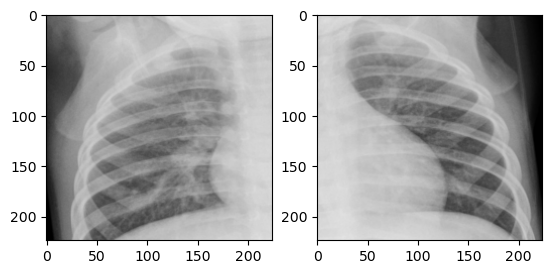

In [14]:
# len(train_dataloader.dataset)  # 7902개의 이미지
from torchvision.transforms.functional import to_pil_image
left_img = to_pil_image(left[38])  # 1 batch (64 images) 중 38번째
right_img = to_pil_image(right[38])
plt.subplot(1,2,1), plt.imshow(left_img)
plt.subplot(1,2,2), plt.imshow(right_img)

In [15]:
print(f"Left Image Shape : {left[0].shape}")
print(f"Right Image Shape : {right[0].shape}")
print(f"Left Image Shape : {label[0].shape}")

Left Image Shape : torch.Size([3, 224, 224])
Right Image Shape : torch.Size([3, 224, 224])
Left Image Shape : torch.Size([3])


# Define Model

In [16]:
import timm

class Model(nn.Module):
    def __init__(self, classes=3):
        super().__init__()
        self.L_model = timm.create_model('resnet50', pretrained=True)
        self.R_model = timm.create_model('resnet50', pretrained=True)
        self.L_model.global_pool = nn.Identity()
        self.L_model.fc = nn.Identity()
        self.R_model.global_pool = nn.Identity()
        self.R_model.fc = nn.Identity()
        self.reduction1 = nn.Conv2d(4096, 1024, 1, 1)  # (IN, OUT, Kernel, Stride, Padding)
        self.reduction2 = nn.Conv2d(1024, 512, 1, 1)  # 1x1 Conv -> Dimension Reduction
        self.reduction3 = nn.Conv2d(512, 128, 1, 1)
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten(start_dim=1,end_dim=3)
        self.fc = nn.Linear(128, classes)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, y):  # x: 왼쪽 이미지, y: 오른쪽 이미지
        x = self.L_model(x)
        y = self.R_model(y)
        xy = torch.cat([x, y], dim=1)  # torch.size(): [batch, channel, height, width] -> dim=3으로 바꿔서 돌려보기 (width 방향 concat)
        xy = self.reduction1(xy)
        xy = self.reduction2(xy)
        xy = self.reduction3(xy)
        xy = self.global_pool(xy)
        xy = self.flatten(xy)
        xy = self.fc(xy)
        xy = self.softmax(xy)

        return xy

In [17]:
model = Model().to(device)
model

Model(
  (L_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, moment

# Define Loss, Optimizer

In [18]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LR'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.4)

# Training

In [19]:
def train_loop(dataloader, model, optimizer, loss_fn, model_save_path):
    model.train()

    size = len(dataloader)  # 124 batches in 1 epoch
    datasize = len(dataloader.dataset)  # 7902 images in total

    loss_hist=[]
    acc_hist=[]

    for epoch in range(CFG['EPOCHS']):
        epoch_start = time.time()

        loss_item=0
        correct=0
        print(f"Start epoch : {epoch+1}")
        for batch, (L, R, y) in enumerate(dataloader):
            L = L.to(device).float()
            R = R.to(device).float()
            y = y.to(device).float()

            output = model(L, R)

            loss = loss_fn(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_item += loss.item()

            correct+=(output.argmax(1)==y.argmax(1)).detach().cpu().sum().item()

            if batch % 30 == 0:
                print(f"Batch loss : {(loss):>.5f} {batch}/{size}")

        loss_hist.append(loss_item/size)
        acc_hist.append(correct/datasize*100)

        print(f"Loss : {(loss_item/size):>.5f} ACC : {(correct/datasize*100):>.2f}%")

        epoch_end = time.time()
        print(f"End epoch : {epoch+1}")
        print(f"Epoch time : {(epoch_end-epoch_start)//60} min {(epoch_end-epoch_start)%60} sec")
        print()

    torch.save(model.state_dict(), model_save_path)

    return loss_hist, acc_hist

In [20]:
loss_hist, acc_hist = train_loop(train_dataloader, model, optimizer, loss_fn, CFG['model_save_path'])

Start epoch : 1


Batch loss : 1.10356 0/124
Batch loss : 1.09690 30/124
Batch loss : 1.08353 60/124
Batch loss : 1.05463 90/124
Batch loss : 0.99224 120/124
Loss : 1.07252 ACC : 49.54%
End epoch : 1
Epoch time : 5.0 min 35.22824573516846 sec

Start epoch : 2
Batch loss : 0.97818 0/124
Batch loss : 0.96984 30/124
Batch loss : 0.87482 60/124
Batch loss : 0.83931 90/124
Batch loss : 0.86952 120/124
Loss : 0.88521 ACC : 70.64%
End epoch : 2
Epoch time : 5.0 min 32.36393404006958 sec

Start epoch : 3
Batch loss : 0.79790 0/124
Batch loss : 0.78309 30/124
Batch loss : 0.81700 60/124
Batch loss : 0.81399 90/124
Batch loss : 0.80884 120/124
Loss : 0.79806 ACC : 76.31%
End epoch : 3
Epoch time : 5.0 min 33.96721529960632 sec

Start epoch : 4
Batch loss : 0.77777 0/124
Batch loss : 0.77656 30/124
Batch loss : 0.73418 60/124
Batch loss : 0.74476 90/124
Batch loss : 0.77269 120/124
Loss : 0.75946 ACC : 79.63%
End epoch : 4
Epoch time : 5.0 min 32.21182441711426 sec

Start epoch : 5
Batch loss : 0.70935 0/124
Batch

Text(0.5, 1.0, 'Train Loss')

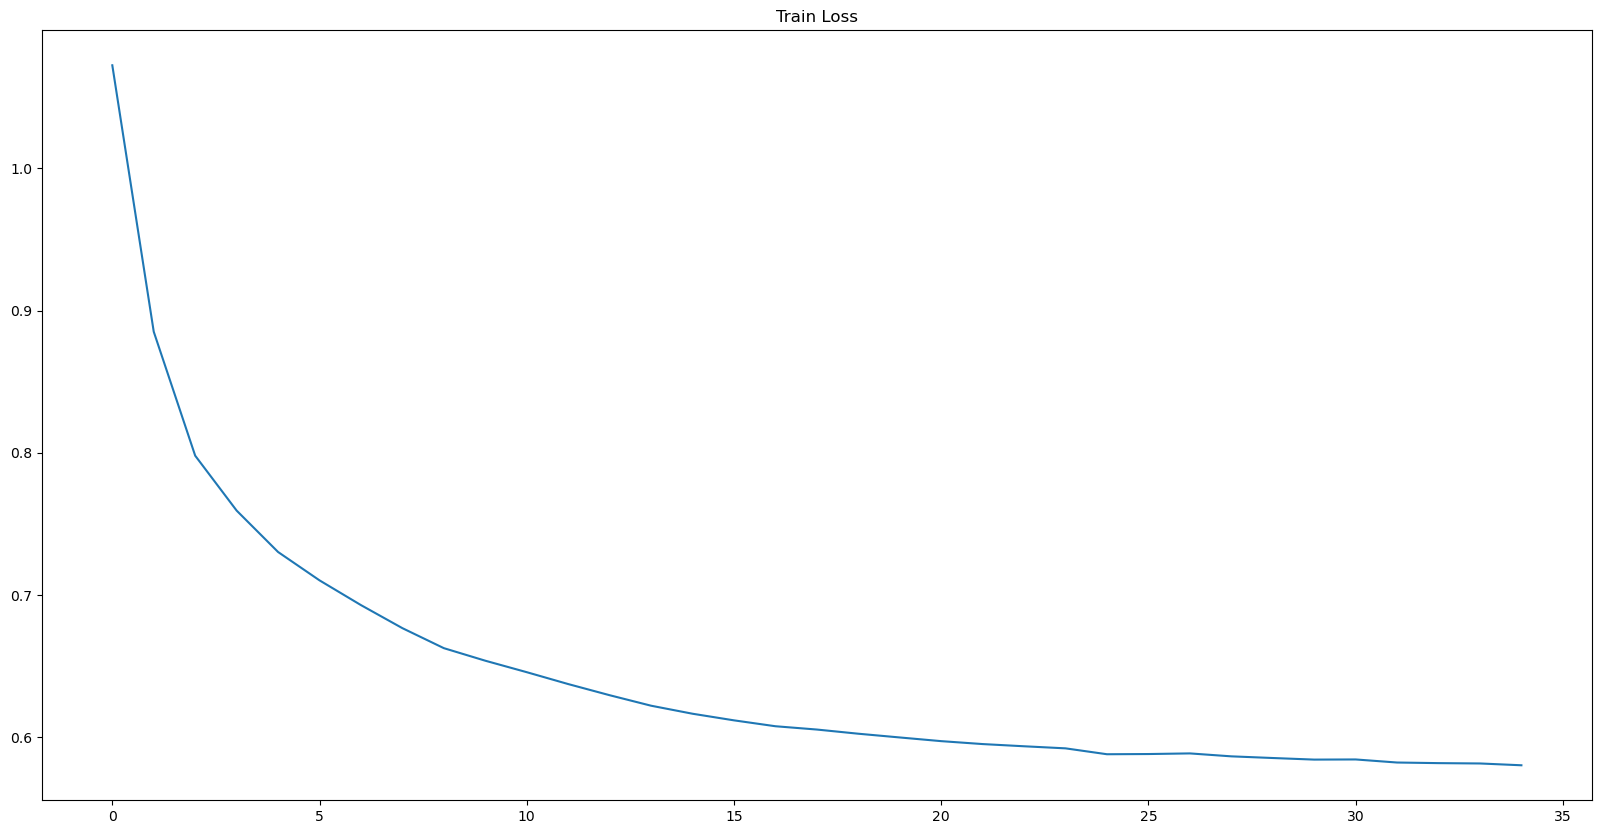

In [21]:
plt.figure(figsize=(20,10))
plt.plot(loss_hist)
plt.title('Train Loss')

Text(0.5, 1.0, 'Train Accuracy')

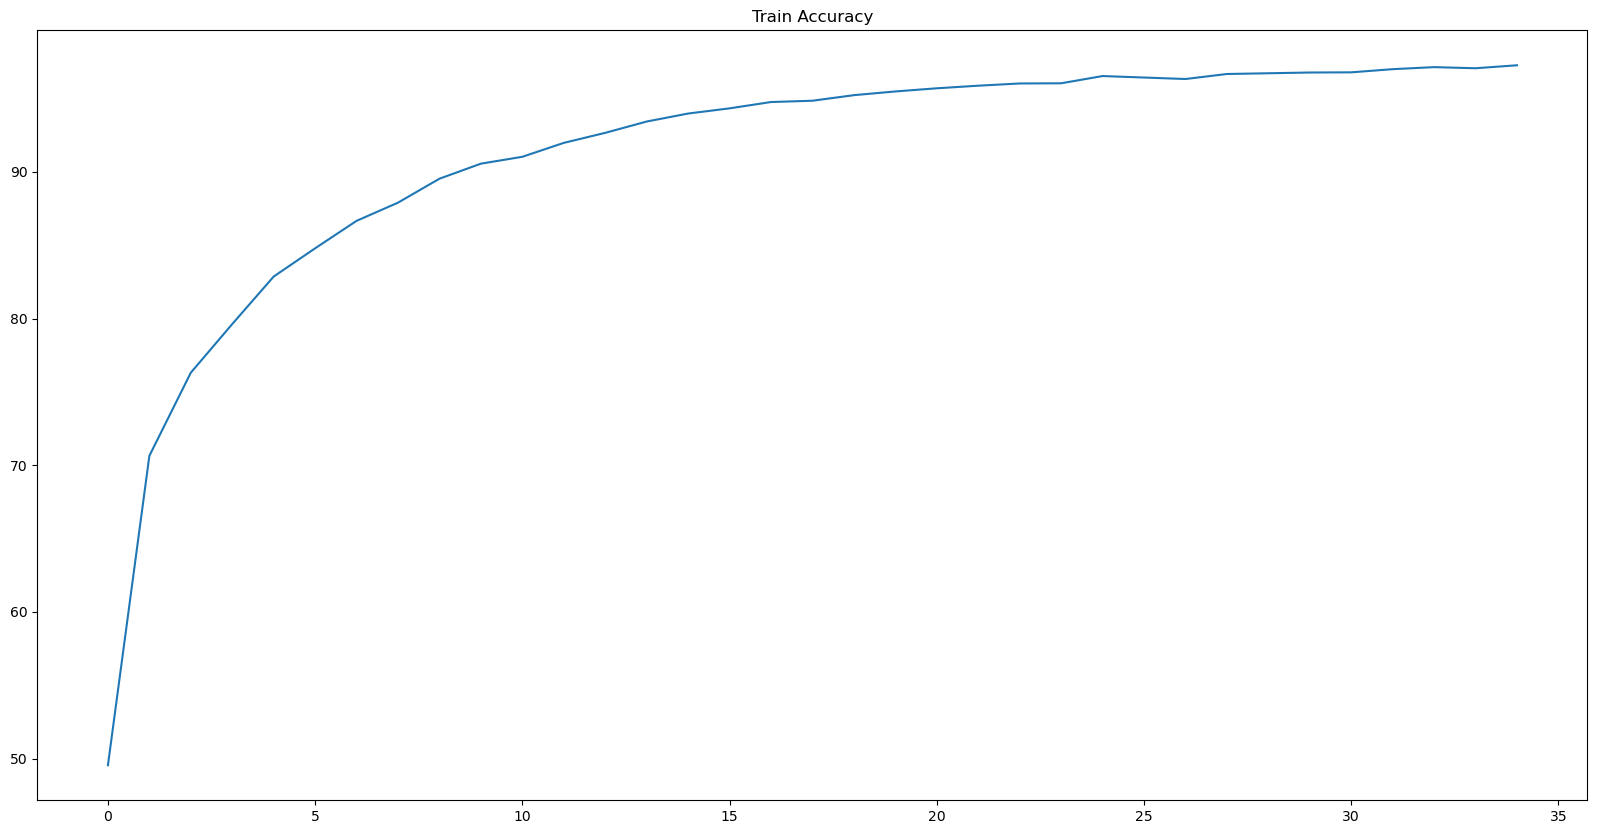

In [22]:
plt.figure(figsize=(20,10))
plt.plot(acc_hist)
plt.title('Train Accuracy')

# TEST

In [23]:
test_crop_dataset = Cropdataset(test_data, test_label, test_transform)  # [LEFT, RIGHT, LABEL]
test_aug_dataset = Augmentedataset(test_vir, test_vir_label, test_transform)  # [LEFT, RIGHT, LABEL]
test_dataset = test_crop_dataset + test_aug_dataset
test_dataloader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

In [24]:
def test_loop(dataloader, model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    pred_normal=[]
    pred_virus=[]
    pred_bacteria=[]
    label_normal=[]
    label_virus=[]
    label_bacteria=[]
    
    label=[]
    pred=[]

    for (L, R, y) in dataloader:
        for t in y:
            label.append(t.detach().tolist())
            label_normal.append(t[0].detach().tolist())
            label_virus.append(t[1].detach().tolist())
            label_bacteria.append(t[2].detach().tolist())

        L = L.to(device).float()
        R = R.to(device).float()
        y = y.to(device).float()

        output = model(L, R)

        for o in output:
            pred.append(o.detach().cpu().tolist())
            pred_normal.append(o[0].detach().cpu().tolist())
            pred_virus.append(o[1].detach().cpu().tolist())
            pred_bacteria.append(o[2].detach().cpu().tolist())

    return label_normal, label_virus, label_bacteria, pred_normal, pred_virus, pred_bacteria, np.array(label), np.array(pred)

In [25]:
label_normal, label_virus, label_bacteria, pred_normal, pred_virus, pred_bacteria, label, pred  = test_loop(test_dataloader, model, CFG['model_save_path'])

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns

In [27]:
OH_pred = []

for vector in pred:
    OH_pred.append(np.argmax(vector, axis=0))

OH_label = []

for vector in label:
    OH_label.append(np.argmax(vector, axis=0))

<Axes: >

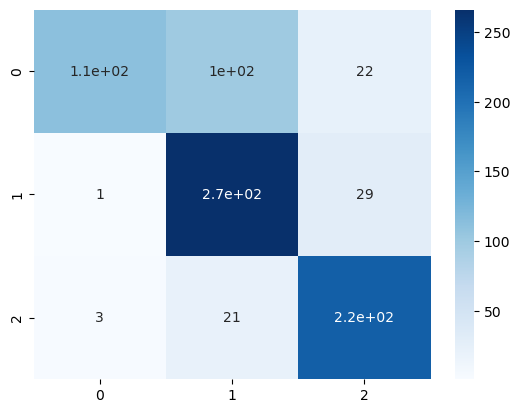

In [28]:
cm = confusion_matrix(OH_label, OH_pred)
sns.heatmap(cm, annot=True, cmap='Blues')

In [29]:
def correct_count(pred, label):
    total = len(pred)  # Test 데이터 개수
    n_correct = 0
    v_correct = 0
    b_correct = 0

    for idx in range(total):
        pred_idx = np.argmax(pred[idx], axis=0)
        label_idx = np.argmax(label[idx], axis=0)

        if (pred_idx == label_idx):
            if pred_idx == 0:  # Normal
                n_correct += 1
            elif pred_idx == 1:  # Virus
                v_correct += 1
            elif pred_idx == 2:  # Bacteria
                b_correct += 1
    
    return n_correct, v_correct, b_correct

In [30]:
def nvb_size(label):
    total = len(label)
    total_n = 0
    total_v = 0
    total_b = 0

    for idx in range(total):
        now = label[idx]
        if now[0] == 1:
            total_n += 1
        elif now[1] == 1:
            total_v += 1
        elif now[2] == 1:
            total_b += 1
        
    return total_n, total_v, total_b

In [31]:
total_n, total_v, total_b = nvb_size(label)
n_correct, v_correct, b_correct = correct_count(pred, label)

print(f"Normal sensitivity: {n_correct/total_n}")
print(f"Virus sensitivity: {v_correct/total_v}")
print(f"Bacteria sensitivity: {b_correct/total_b}")

Normal sensitivity: 0.47863247863247865
Virus sensitivity: 0.8986486486486487
Bacteria sensitivity: 0.9008264462809917
